In [1]:
import numpy as np
from matplotlib import pyplot as plt
import profess_io as pio
import glob
import os
import pandas as pd

In [2]:
def get_lv_comp(lvs, comp):
    """
    returns lattice vector component
    """
    a_comp = []
    for i in range(len(lvs)):
        a_comp.append( lvs[i][comp[0]][comp[1]] )
    return(np.array(a_comp))

def get_positions(trajectory_dir, ion_numbers):
    trajectories = glob.glob(os.path.join(trajectory_dir, 'ion.*.dat'))
    coords = []
    for i in ion_numbers:
        if i == 0:
            path = os.path.join(trajectory_dir, f'ion.1.dat')
        else:
            path = os.path.join(trajectory_dir, f'ion.{i}.dat')
        coords_step = np.array(pio.parse_ion_file(path))
        coords.append(coords_step)
    coords = np.array(coords)
    return(coords)

def collect_data(file, ion_numbers=None, trajectory_dir = None, keys='all'):
    if keys == 'all':
        data = {'ekin':[], 'epot':[], 'positions': [], 'frac_x':[], 'frac_y':[], 'frac_z':[], 'lattice_vectors': [], 'pressure': [], 'temperature': [], 'volume': []}
    else:
        data = {key: [] for key in keys}
        
    for k in data.keys():
        # pressure and volume will be calculated later
        if k not in ['volume']:
            data[k] = pio.parse_out_file(file, k)
            data[k] = np.array(data[k])
        
    # get lattice vector components
    if 'lattice_vectors' in data:
        for i in range(3):
            for j in range(3):
                data[f'l_{i}{j}'] = get_lv_comp(data['lattice_vectors'], (i,j))
    
    # calculate volume
    if 'volume' in data:
        for l in data['lattice_vectors']:
            data['volume'].append(np.linalg.det(l))
        data['volume'] = np.array(data['volume'])
    
    # calculate pressure
    if 'pressure' in data:
        bohr2m = 5.29177e-11
        auf2N = 8.2387225e-8
        data['pressure'] = data['pressure']/data['volume']*auf2N/bohr2m**2
    
    # get atom positions
    if 'positions' in data:
        data['positions'] = get_positions(trajectory_dir, ion_numbers)
        
        
    return(data)

def plot_data_NVT(data, num_plots = 6):
    plt.rcParams['figure.figsize'] = [10,30]
    plt.rcParams['font.size'] = 15
    fig, ax = plt.subplots(num_plots,1)
    
#     # plot l_ii
#     for i in range(3):
#         ax[1].plot(data['time'], data[f'l_{i}{i}'], label = f'a_{i}{i}')
#         ax[1].set_xlabel(r'$t$ (fs)')
#         ax[1].set_ylabel(r'$a_{ii}$ (Ang)')
#         ax[1].legend()

    # temperature
    ax[0].plot(data['time'], data['temperature'])
    ax[0].set_xlabel(r'$t$ (fs)')
    ax[0].set_ylabel(r'$T$ (K)')

    # epot
    ax[1].plot(data['time'], data['epot'])
    ax[1].set_xlabel(r'$t$ (fs)')
    ax[1].set_ylabel(r'$E_{\rm{pot}}$ (eV)')

    # epot
    ax[2].plot(data['time'], data['ekin'])
    ax[2].set_xlabel(r'$t$ (fs)')
    ax[2].set_ylabel(r'$E_{\rm{kin}}$ (eV)')
    
    if 'positions' in data:
        # coordinates
        for ai, c in zip([3,4,5], [0,1,2]):
            plot_coordinate(ax, ai, data['time_coords'], data['positions'], c)
    return(fig,ax)
    
def plot_coordinate(ax, ax_idx, time, positions, coord):
    for atom in range(positions.shape[1]):
        ax[ax_idx].plot(time, positions[:,atom,coord], label = f'Si {atom}')
    ax[ax_idx].set_xlabel(r'$t$ (fs)')
    if coord == 0:
        coord_label = 'x'
    elif coord == 1:
        coord_label = 'y'
    elif coord == 2:
        coord_label = 'z'
    ax[ax_idx].set_ylabel(coord_label)
    ax[ax_idx].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    

### Pick equilibrium positions and velocities for NVE run

In [4]:
paths = glob.glob('/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/ion.*.dat')
num = []
for p in paths:
    num.append(int(p.split('.')[-2]))
max_file = max(num)

In [5]:
ion_numbers = np.arange(0, max_file+1, 10)
ion_numbers[0] = 1
trajectory_dir = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/'
positions = get_positions(trajectory_dir, ion_numbers)
time = ion_numbers/10

In [6]:
positions.shape

(31754, 8, 3)

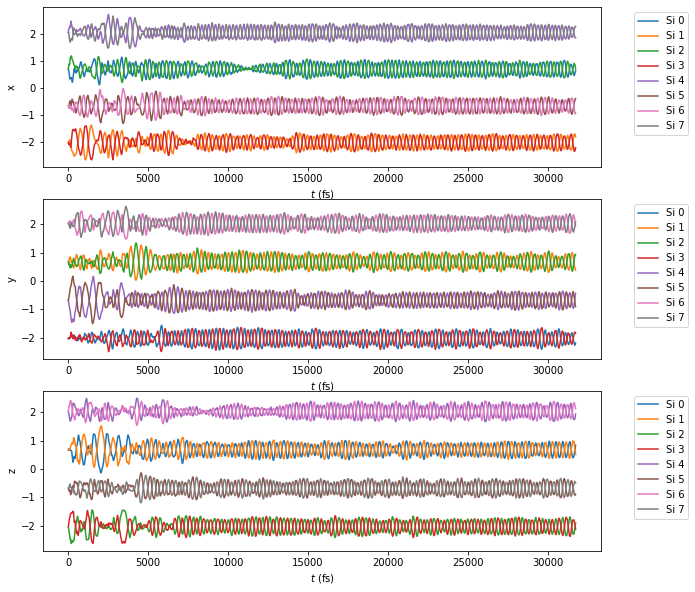

In [10]:
plt.rcParams['figure.figsize'] = [10,10]
fig, ax = plt.subplots(3,1)
a = 0
e = -1
for i in range(3):
    plot_coordinate(ax, i, time[a:e], positions[a:e], i)

# f,a=plot_data_NVT(data)
# f.subplots_adjust(top=0.97)
# p = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT/figures/QMAS3e3.png'
# f.suptitle('QMAS = 3e3, conv < 1e-5')
# f.savefig(p, bbox_inches='tight')

In [12]:
keys = {'ekin':[], 'epot':[],'temperature': []}
file = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/hc.out'
ion_numbers = None
# ion_numbers[0] = None
trajectory_dir = None
data = collect_data(file, ion_numbers, trajectory_dir, keys)
# data['time'] = np.arange(0, 5000+0.1, 0.1)
# data['time_coords'] = np.arange(0, 5000+0.1, 2)
# f,a=plot_data_NVT(data)
# f.subplots_adjust(top=0.97)
# p = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT/figures/QMAS3e3.png'
# f.suptitle('QMAS = 3e3, conv < 1e-5')
# f.savefig(p, bbox_inches='tight')

In [70]:
temp10 = data['temperature'][0:-1:10]

In [74]:
len(temp10[25000-100:25000+100])

200

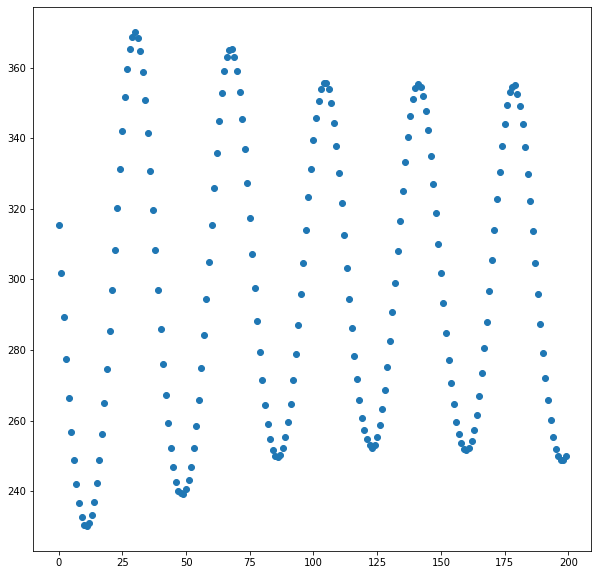

In [73]:
time = np.arange(0, len(data['temperature'])/10+0.1, 0.1)
plt.plot(temp10[25000-100:25000+100], 'o')

In [66]:
len(data['temperature'])

318361

In [26]:
250000/10

25000.0

In [83]:
b2m = 5.29177e-11
aut2s = 2.418884326509e-17
aum2kg =  1.66053904e-27
vel_atu2si = b2m/aut2s
N = 8
kB = 1.38064852e-23
vel = np.array(pio.parse_velocity_file('/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/vel.249960.dat'))
temperature = np.sum(np.power(vel*vel_atu2si,2))*28.0855*aum2kg/(2*N)*2/3/kB
print(temperature)

304.76463285792335


In [81]:
# this is the one
'/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/vel.249960.dat'

'/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT_ref/vel.249960.dat'

In [47]:
np.sum(np.power(vel*vel_atu2si,2))*28.0855*aum2kg/(2*N)*2/3/kB

254.60542820610087

In [40]:
121.00951364**2

14643.302391389345

# Calculate rolling average

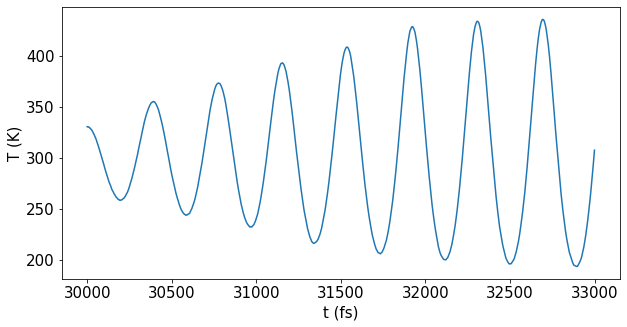

In [50]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(30000, 33000, 1) , data['temperature'][30000:33000])
ax.set_xlabel('t (fs)')
ax.set_ylabel('T (K)')

p = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT/figures/time_excerpt.png'
fig.savefig(p, bbox_inches='tight')

In [16]:
window = 1500
averaged_temp = data_pd.rolling(window).mean()

fig, ax = plt.subplots(2,1)
ax[0].plot(data['temperature'])
ax[0].set_xlabel('step')
ax[0].set_ylabel('T (K)')

ax[1].plot(averaged_temp[window:])
ax[1].set_xlabel('step')
ax[1].set_ylabel('T (K)')

p = '/home/misa/projects/APDFT-CPMD/data/BOMD/Si8_hc_NVT/figures/rolling_mean.png'
fig.savefig(p, bbox_inches='tight')

NameError: name 'data_pd' is not defined